In [1]:
# coding: utf-8
#---------------------------------------------------------------------
'''
Neural Machine Translation - Translation experiments
    Training, evaluation and prediction functions
'''
#---------------------------------------------------------------------

# In[ ]:

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm
import sys
import os
from collections import Counter
import math
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import matplotlib.gridspec as gridspec
import importlib
%matplotlib inline

Japanese English dataset configuration
vocab size, en=3713, fr=3949
--------------------------------------------------
68.554
682.0324173333852
43.82380952380952
949.785182666621


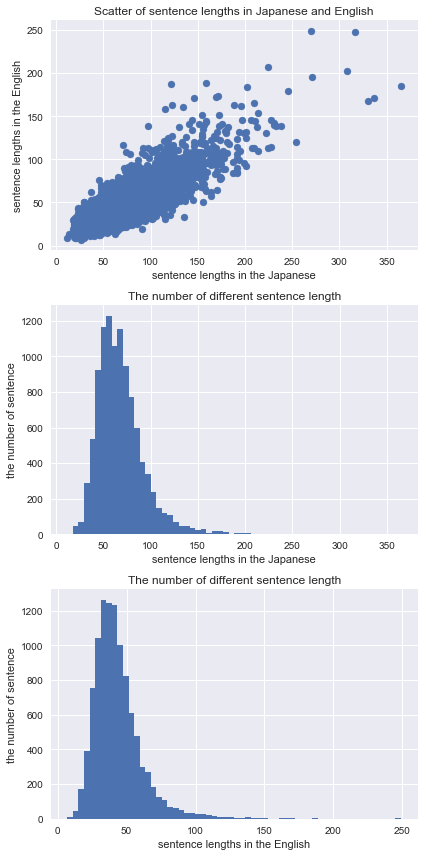

In [2]:


# In[ ]:

#---------------------------------------------------------------------
# Load configuration
#---------------------------------------------------------------------
from nmt_config import *

# In[ ]:
#---------------------------------------------------------------------
# Load encoder decoder model definition
#---------------------------------------------------------------------
from enc_dec import *

# In[ ]:

xp = cuda.cupy if gpuid >= 0 else np

# In[ ]:
#---------------------------------------------------------------------
# Load dataset
#---------------------------------------------------------------------
w2i = pickle.load(open(w2i_path, "rb"))
i2w = pickle.load(open(i2w_path, "rb"))
vocab = pickle.load(open(vocab_path, "rb"))
vocab_size_en = min(len(i2w["en"]), max_vocab_size["en"])
vocab_size_fr = min(len(i2w["fr"]), max_vocab_size["fr"])
print("vocab size, en={0:d}, fr={1:d}".format(vocab_size_en, vocab_size_fr))
print("{0:s}".format("-"*50))
#---------------------------------------------------------------------

# In[ ]:
sent_length = {"len_fr":[], "len_en":[]}
en_tokens={}
fr_tokens={}
with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
    for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
        sent_length['len_fr'].append(len(line_fr))
        sent_length['len_en'].append(len(line_en))    
        for token in line_fr.split():
            if token in fr_tokens:
                fr_tokens[token] += 1
            else:
                fr_tokens[token] = 1
        for token in line_en.split():
            if token in en_tokens:
                en_tokens[token] += 1
            else:
                en_tokens[token] = 1
sum = 0
for a in range(len(sent_length['len_fr'])):
    sum += sent_length["len_fr"][a]
average = sum / len(sent_length['len_fr'])
print (average)
sum = 0
for b in range(len(sent_length['len_fr'])):
    sum += (sent_length['len_fr'][b] - average) ** 2
stev = sum / len(sent_length['len_fr'])
print (stev)
sum = 0
for a in range(len(sent_length['len_en'])):
    sum += sent_length["len_en"][a]
average2 = sum / len(sent_length['len_en'])
print (average2)
sum = 0
for b in range(len(sent_length['len_en'])):
    sum += (sent_length['len_en'][b] - average) ** 2
stev2 = sum / len(sent_length['len_en'])
print (stev2)

fig = plt.figure(figsize=(6,12))
ax1 = fig.add_subplot(3,1,1)
ax1.scatter(sent_length['len_fr'], sent_length['len_en'])
plt.xlabel('sentence lengths in the Japanese')
plt.ylabel('sentence lengths in the English')
plt.title('Scatter of sentence lengths in Japanese and English')
ax2 = fig.add_subplot(3,1,2)
ax2.hist(sent_length['len_fr'], bins = 60)
plt.xlabel('sentence lengths in the Japanese')
plt.ylabel('the number of sentence')
plt.title('The number of different sentence length')
ax3 = fig.add_subplot(3,1,3)
ax3.hist(sent_length['len_en'], bins = 60)
plt.xlabel('sentence lengths in the English')
plt.ylabel('the number of sentence')
plt.title('The number of different sentence length')
fig.tight_layout()
fig.savefig("1.png",dpi=200)
plt.show()

In [3]:
# In[ ]:
en_sum=0
fr_sum=0
for item in fr_tokens:
    fr_sum += fr_tokens[item]
for item in en_tokens:
    en_sum += en_tokens[item]
unk_token_en = 0
unk_token_fr = 0
for item in fr_tokens:
    if fr_tokens[item] == 1:
        unk_token_fr += 1
for item in en_tokens:
    if en_tokens[item] == 1:
        unk_token_en += 1
print("Word tokens in English: {0}".format(en_sum))
print("Word tokens in Japanese: {0}".format(fr_sum))
print("Word types in English: {0}".format(len(en_tokens)))
print("Word types in Japanese: {0}".format(len(fr_tokens)))
print("Unknow word tokens in English: {0}".format(unk_token_en))
print("Unknow word tokens in Japanese: {0}".format(unk_token_fr))

Word tokens in English: 97643
Word tokens in Japanese: 143581
Word types in English: 7211
Word types in Japanese: 8252
Unknow word tokens in English: 3384
Unknow word tokens in Japanese: 4172


In [1]:
# coding: utf-8
#---------------------------------------------------------------------
'''
Neural Machine Translation - Translation experiments
    Training, evaluation and prediction functions
'''
#---------------------------------------------------------------------

# In[ ]:

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm
import sys
import os
from collections import Counter
import math
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import matplotlib.gridspec as gridspec
import importlib
# %matplotlib inline

# In[ ]:

#---------------------------------------------------------------------
# Load configuration
#---------------------------------------------------------------------
from nmt_config import *

# In[ ]:
#---------------------------------------------------------------------
# Load encoder decoder model definition
#---------------------------------------------------------------------
from enc_dec import *

# In[ ]:

xp = cuda.cupy if gpuid >= 0 else np

# In[ ]:
#---------------------------------------------------------------------
# Load dataset
#---------------------------------------------------------------------
w2i = pickle.load(open(w2i_path, "rb"))
i2w = pickle.load(open(i2w_path, "rb"))
vocab = pickle.load(open(vocab_path, "rb"))
vocab_size_en = min(len(i2w["en"]), max_vocab_size["en"])
vocab_size_fr = min(len(i2w["fr"]), max_vocab_size["fr"])
print("vocab size, en={0:d}, fr={1:d}".format(vocab_size_en, vocab_size_fr))
print("{0:s}".format("-"*50))
#---------------------------------------------------------------------

# In[ ]:
#---------------------------------------------------------------------
# Set up model
#---------------------------------------------------------------------
model = EncoderDecoder(vocab_size_fr, vocab_size_en,
                       num_layers_enc, num_layers_dec,
                       hidden_units, gpuid, attn=use_attn)
if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

optimizer = optimizers.Adam()
optimizer.setup(model)

'''
___QUESTION-1-DESCRIBE-F-START___

- Describe what the following line of code does
'''
optimizer.add_hook(chainer.optimizer.GradientClipping(threshold=5))
'''___QUESTION-1-DESCRIBE-F-END___'''

# In[ ]:

#---------------------------------------------------------------------
print("Training progress will be logged in:\n\t{0:s}".format(log_train_fil_name))
print("{0:s}".format("-"*50))
print("Trained model will be saved as:\n\t{0:s}".format(model_fil))
print("{0:s}".format("-"*50))
#---------------------------------------------------------------------

# In[ ]:
#---------------------------------------------------------------------
# Evaluation utilities
#---------------------------------------------------------------------
# Compute perplexity over validation set
def compute_dev_pplx():
    loss = 0
    num_words = 0
    num_sents = 0
    with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
        with tqdm(total=NUM_DEV_SENTENCES) as pbar:
            sys.stderr.flush()
            out_str = "loss={0:.6f}".format(0)
            pbar.set_description(out_str)
            for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
                if i > NUM_TRAINING_SENTENCES and i <= (NUM_TRAINING_SENTENCES + NUM_DEV_SENTENCES):
                    fr_sent = line_fr.strip().split()
                    en_sent = line_en.strip().split()

                    fr_ids = [w2i["fr"].get(w, UNK_ID) for w in fr_sent]
                    en_ids = [w2i["en"].get(w, UNK_ID) for w in en_sent]

                    # compute loss
                    curr_loss = float(model.encode_decode_train(fr_ids, en_ids, train=False).data)  / len(en_ids)
                    loss += curr_loss
                    num_words += len(en_ids)

                    out_str = "loss={0:.6f}".format(curr_loss)
                    pbar.set_description(out_str)
                    pbar.update(1)
                    num_sents += 1
                
            # end for
        # end pbar
    # end with open file
    #loss_per_word = loss / num_words
    loss_per_sentence = loss / num_sents
    pplx = 2 ** loss_per_sentence

    print("{0:s}".format("-"*50))
    print("{0:14s} | {1:.4f}".format("dev perplexity", pplx))
    print("{0:14s} | {1:d}".format("# words in dev", num_words))
    print("{0:s}".format("-"*50))

    return pplx

# In[ ]:
#---------------------------------------------------------------------
# Compute Bleu score
#---------------------------------------------------------------------
def bleu_stats(hypothesis, reference):
    yield len(hypothesis)
    yield len(reference)
    for n in range(1,5):
        s_ngrams = Counter([tuple(hypothesis[i:i+n]) for i in range(len(hypothesis)+1-n)])
        r_ngrams = Counter([tuple(reference[i:i+n]) for i in range(len(reference)+1-n)])
        yield max([sum((s_ngrams & r_ngrams).values()), 0])
        yield max([len(hypothesis)+1-n, 0])

# Compute BLEU from collected statistics obtained by call(s) to bleu_stats
def bleu(stats):
    if len(list(filter(lambda x: x==0, stats))) > 0:
        return 0
    (c, r) = stats[:2]
    log_bleu_prec = sum([math.log(float(x)/y) for x,y in zip(stats[2::2],stats[3::2])]) / 4.
    return math.exp(min([0, 1-float(r)/c]) + log_bleu_prec)

def compute_dev_bleu():
    list_of_references = []
    list_of_hypotheses = []
    with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
        for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
            if i > NUM_TRAINING_SENTENCES and i <= (NUM_TRAINING_SENTENCES + NUM_DEV_SENTENCES):
                fr_sent = line_fr.strip().split()
                en_sent = line_en.strip().split()

                fr_ids = [w2i["fr"].get(w, UNK_ID) for w in fr_sent]
                en_ids = [w2i["en"].get(w, UNK_ID) for w in en_sent]

                list_of_references.append(line_en.strip().decode())
                pred_sent, alpha_arr = model.encode_decode_predict(fr_ids, max_predict_len=MAX_PREDICT_LEN)
                pred_words = [i2w["en"][w].decode() for w in pred_sent if w != EOS_ID]
                pred_sent_line = " ".join(pred_words)
                list_of_hypotheses.append(pred_sent_line)
            if i > (NUM_TRAINING_SENTENCES + NUM_DEV_SENTENCES):
                break

    stats = [0 for i in range(10)]
    for (r,h) in zip(list_of_references, list_of_hypotheses):
        stats = [sum(scores) for scores in zip(stats, bleu_stats(h,r))]

    bleu_score = (100 * bleu(stats))
    print("BLEU: {0:0.3f}".format(bleu_score))
    return bleu_score

# In[ ]:
#---------------------------------------------------------------------
# Main training loop
#---------------------------------------------------------------------
def train_loop(text_fname, num_training, num_epochs, log_mode="a"):
    # Set up log file for loss
    log_train_fil = open(log_train_fil_name, mode=log_mode)
    log_train_csv = csv.writer(log_train_fil, lineterminator="\n")

    sys.stderr.flush()

    for epoch in range(num_epochs):
        with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
            with tqdm(total=num_training) as pbar:
                sys.stderr.flush()
                loss_per_epoch = 0
                out_str = "epoch={0:d}, iter={1:d}, loss={2:.6f}, mean loss={3:.6f}".format(
                                epoch+1, 0, 0, 0)
                pbar.set_description(out_str)

                for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
                    fr_sent = line_fr.strip().split()
                    en_sent = line_en.strip().split()

                    fr_ids = [w2i["fr"].get(w, UNK_ID) for w in fr_sent]
                    en_ids = [w2i["en"].get(w, UNK_ID) for w in en_sent]

                    it = (epoch * NUM_TRAINING_SENTENCES) + i

                    if i > num_training:
                        break

                    # compute loss
                    loss = model.encode_decode_train(fr_ids, en_ids)

                    # clear gradient
                    model.cleargrads()
                    # backprop
                    loss.backward()
                    # update parameters
                    optimizer.update()
                    # store loss value for display
                    loss_val = float(loss.data) / len(en_ids)
                    loss_per_epoch += loss_val

                    out_str = "epoch={0:d}, iter={1:d}, loss={2:.6f}, mean loss={3:.6f}".format(
                               epoch+1, it, loss_val, (loss_per_epoch / i))
                    pbar.set_description(out_str)
                    pbar.update(1)

                    # log every 100 sentences
                    if i % 100 == 0:
                        log_train_csv.writerow([it, loss_val])


        # compute precision, recall and F-score
        metrics = predict(s=NUM_TRAINING_SENTENCES, 
                         num=NUM_DEV_SENTENCES, display=False, plot=False)
        prec = np.sum(metrics["cp"]) / np.sum(metrics["tp"])
        rec = np.sum(metrics["cp"]) / np.sum(metrics["t"])
        f_score = 2 * (prec * rec) / (prec + rec)

        print("{0:s}".format("-"*50))
        print("{0:10s} | {1:0.4f}".format("precision", prec))
        print("{0:10s} | {1:0.4f}".format("recall", rec))
        print("{0:10s} | {1:0.4f}".format("f1", f_score))
        print("{0:s}".format("-"*50))
        print("computing perplexity")
        pplx = compute_dev_pplx()

        # Backup model every epoch
        print("Saving model")
        serializers.save_npz(model_fil, model)
        print("Finished saving model")
        print("{0:s}".format("-"*50))

        # Compute Bleu every 2 epochs
        if epoch % 2 == 0:
            print("computing bleu")
            bleu_score = compute_dev_bleu()
            print("finished computing bleu ... ")
            print("{0:s}".format("-"*50))
        
    # At the end of training, make some predictions
    # make predictions over both training and dev sets
    print("Training set predictions")
    _ = predict(s=0, num=3, plot=False)
    print("{0:s}".format("-"*50))
    print("dev set predictions")
    _ = predict(s=NUM_TRAINING_SENTENCES, num=3, plot=False)
    print("{0:s}".format("-"*50))

    print("{0:s}".format("-"*50))
    # Check if Bleu needs to be recomputed
    if num_epochs % 2 != 0:
        bleu_score = compute_dev_bleu()
        print("{0:s}".format("-"*50))
    print("{0:s}".format("-"*50))

    # close log file
    log_train_fil.close()
    print("Finished training. Filenames:")
    print(log_train_fil_name)
    print(model_fil)

# In[ ]:
#---------------------------------------------------------------------
# __QUESTION -- Following code is to assist with ATTENTION
#---------------------------------------------------------------------
from matplotlib.font_manager import FontProperties
'''
Support function to plot attention vectors
'''
def plot_attention(alpha_arr, fr, en, plot_name=None):
    if gpuid >= 0:
        alpha_arr = cuda.to_cpu(alpha_arr).astype(np.float32)

    #alpha_arr /= np.max(np.abs(alpha_arr),axis=0)
    fig = plt.figure()
    fig.set_size_inches(8, 8)

    gs = gridspec.GridSpec(2, 2, width_ratios=[12,1],height_ratios=[12,1])

    ax = plt.subplot(gs[0])
    ax_c = plt.subplot(gs[1])

    cmap = sns.light_palette((200, 75, 60), input="husl", as_cmap=True)
    prop = FontProperties(fname='fonts/IPAfont00303/ipam.ttf', size=12)
    ax = sns.heatmap(alpha_arr, xticklabels=fr, yticklabels=en, ax=ax, cmap=cmap, cbar_ax=ax_c)

    ax.xaxis.tick_top()
    ax.yaxis.tick_right()

    ax.set_xticklabels(en, minor=True, rotation=60, size=12)
    for label in ax.get_xticklabels(minor=False):
        label.set_fontsize(12)
        label.set_font_properties(prop)

    for label in ax.get_yticklabels(minor=False):
        label.set_fontsize(12)
        label.set_rotation(-90)
        label.set_horizontalalignment('left')

    ax.set_xlabel("Source", size=20)
    ax.set_ylabel("Hypothesis", size=20)

    if plot_name:
        fig.savefig(plot_name, format="png")

# In[ ]:

#---------------------------------------------------------------------
# Helper function for prediction
#---------------------------------------------------------------------
def predict_sentence(line_fr, line_en=None, display=True, 
                     plot_name=None, p_filt=0, r_filt=0, sample=False):
    fr_sent = line_fr.strip().split()
    fr_ids = [w2i["fr"].get(w, UNK_ID) for w in fr_sent]
    # english reference is optional. If provided, compute precision/recall
    if line_en:
        en_sent = line_en.strip().split()
        en_ids = [w2i["en"].get(w, UNK_ID) for w in en_sent]

    pred_ids, alpha_arr = model.encode_decode_predict(fr_ids, 
                                                      max_predict_len=MAX_PREDICT_LEN,
                                                      sample=sample)
    pred_words = [i2w["en"][w].decode() for w in pred_ids]

    prec = 0
    rec = 0
    filter_match = False

    matches = count_match(en_ids, pred_ids)
    prec = matches/len(pred_ids)
    rec = matches/len(en_ids)

    if display and (prec >= p_filt and rec >= r_filt):
        filter_match = True
        # convert raw binary into string
        fr_words = [w.decode() for w in fr_sent]

        print("{0:s}".format("-"*50))
        print("{0:s} | {1:80s}".format("Src", line_fr.strip().decode()))
        print("{0:s} | {1:80s}".format("Ref", line_en.strip().decode()))
        print("{0:s} | {1:80s}".format("Hyp", " ".join(pred_words)))

        print("{0:s}".format("-"*50))

        print("{0:s} | {1:0.4f}".format("precision", prec))
        print("{0:s} | {1:0.4f}".format("recall", rec))

        if plot_name and use_attn:
            plot_attention(alpha_arr, fr_words, pred_words, plot_name)

    return matches, len(pred_ids), len(en_ids), filter_match

# In[ ]:
#---------------------------------------------------------------------
'''
Function to make predictions.
s       : starting index of the line in the parallel data from which to make predictions
num     : number of lines starting from "s" to make predictions for
plot    : plot attention if True
display : whether to display additional info
p_filt  : precision filter. Only displays predicted sentences with precision above p_filt
r_filt  : recall filter. Only displays predicted sentences with recall above p_filt
sample  : if False, predict word with maximum probability in the model, else sample
'''
#---------------------------------------------------------------------
def predict(s=NUM_TRAINING_SENTENCES, num=NUM_DEV_SENTENCES, 
            display=True, plot=False, p_filt=0, r_filt=0, sample=False):
    
    if display:
        print("English predictions, s={0:d}, num={1:d}:".format(s, num))

    metrics = {"cp":[], "tp":[], "t":[]}

    filter_count = 0

    with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
        for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=0):
            if i >= s and i < (s+num):
                if plot:
                    plot_name = os.path.join(model_dir, "sample_{0:d}_plot.png".format(i+1))
                else:
                    plot_name=None

                # make prediction
                cp, tp, t, f = predict_sentence(line_fr,
                                             line_en,
                                             display=display,
                                             plot_name=plot_name, 
                                             p_filt=p_filt, r_filt=r_filt,
                                             sample=sample)
                metrics["cp"].append(cp)
                metrics["tp"].append(tp)
                metrics["t"].append(t)
                filter_count += (1 if f else 0)

    if display:
        print("sentences matching filter = {0:d}".format(filter_count))
    
    return metrics


# In[ ]:
#---------------------------------------------------------------------
# Helper function to compute precision recall
#---------------------------------------------------------------------
def count_match(list1, list2):
    # each list can have repeated elements. The count should account for this.
    count1 = Counter(list1)
    count2 = Counter(list2)
    count2_keys = count2.keys()-set([UNK_ID])
    common_w = set(count1.keys()) & set(count2_keys)
    matches = sum([min(count1[w], count2[w]) for w in common_w])
    return matches

# In[ ]:

#---------------------------------------------------------------------
# Main -- program execution starts here
#---------------------------------------------------------------------

def main():
    print("Existing model {0:s}".format("found" if os.path.exists(model_fil) else "not found!"))
    print("{0:s}".format("-"*50))
    if os.path.exists(model_fil):
        if load_existing_model:
            print("loading model ...")
            serializers.load_npz(model_fil, model)
            print("finished loading: {0:s}".format(model_fil))
            print("{0:s}".format("-"*50))
        else:
            print("""model file already exists!!
                Delete before continuing, or enable load_existing flag""".format(model_fil))
            return

    if NUM_EPOCHS > 0:
        train_loop(text_fname, NUM_TRAINING_SENTENCES, NUM_EPOCHS)
    
if __name__ == "__main__":
    main()

#---------------------------------------------------------------------

def test_lam_tran():
    lines_fr = ["君 は １ 日 で それ が でき ま す か 。", "皮肉 な 笑い を 浮かべ て 彼 は 私 を 見つめ た 。", "あなた は 午後 何 を し た い で す か 。"]
    lines_en = ["can you do it in one day ?", "he stared at me with a satirical smile .", "what do you want to do in the afternoon ?" ]

    for line_fr, line_en in zip(lines_fr, lines_en):
        line_fr = line_fr.encode()
        line_en = line_en.encode()

        predict_sentence(line_fr=line_fr, line_en=line_en)




Japanese English dataset configuration
vocab size, en=3713, fr=3949
--------------------------------------------------
Training progress will be logged in:
	model\train_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.log
--------------------------------------------------
Trained model will be saved as:
	model\seq2seq_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.model
--------------------------------------------------
Existing model found
--------------------------------------------------
loading model ...
finished loading: model\seq2seq_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.model
--------------------------------------------------


In [8]:
predict(s=0,num=30,sample=False)


English predictions, s=0, num=30:
--------------------------------------------------
Src | ステーキ は 中位 で 焼 い て くださ い 。                                                       
Ref | i like my steak medium .                                                        
Hyp | i like my steak medium . _EOS                                                   
--------------------------------------------------
precision | 0.8571
recall | 1.0000
--------------------------------------------------
Src | 彼女 の 美し さ に 関 し て は 、 疑 う 余地 が な い 。                                            
Ref | there is no doubt as to her beauty .                                            
Hyp | she is no doubt she her her her . . _EOS                                        
--------------------------------------------------
precision | 0.4545
recall | 0.5556
--------------------------------------------------
Src | この 近所 の 家 は どれ も とても よく 似 て い る の で 見分け が つ か な い 。                             
Ref | all the houses in this nei

{'cp': [6,
  5,
  3,
  4,
  4,
  3,
  4,
  3,
  3,
  2,
  4,
  6,
  3,
  3,
  6,
  7,
  2,
  4,
  2,
  4,
  4,
  4,
  2,
  5,
  6,
  4,
  2,
  2,
  2,
  2],
 't': [6,
  9,
  18,
  7,
  11,
  12,
  9,
  9,
  7,
  11,
  7,
  12,
  8,
  10,
  16,
  8,
  7,
  6,
  5,
  9,
  9,
  8,
  8,
  11,
  10,
  7,
  7,
  6,
  10,
  13],
 'tp': [7,
  11,
  19,
  8,
  11,
  13,
  9,
  12,
  8,
  10,
  9,
  13,
  8,
  10,
  15,
  9,
  7,
  6,
  6,
  10,
  10,
  9,
  10,
  9,
  10,
  8,
  8,
  7,
  10,
  12]}

In [3]:
predict(s=0,num=30,sample=False)

English predictions, s=0, num=30:
--------------------------------------------------
Src | ステーキ は 中位 で 焼 い て くださ い 。                                                       
Ref | i like my steak medium .                                                        
Hyp | i like my steak medium . _EOS                                                   
--------------------------------------------------
precision | 0.8571
recall | 1.0000
--------------------------------------------------
Src | 彼女 の 美し さ に 関 し て は 、 疑 う 余地 が な い 。                                            
Ref | there is no doubt as to her beauty .                                            
Hyp | there is no her her her her . . _EOS                                            
--------------------------------------------------
precision | 0.5000
recall | 0.5556
--------------------------------------------------
Src | この 近所 の 家 は どれ も とても よく 似 て い る の で 見分け が つ か な い 。                             
Ref | all the houses in this nei

{'cp': [6,
  5,
  5,
  5,
  4,
  5,
  3,
  3,
  4,
  3,
  4,
  4,
  3,
  3,
  7,
  8,
  6,
  2,
  2,
  3,
  3,
  1,
  2,
  2,
  7,
  4,
  2,
  3,
  4,
  3],
 't': [6,
  9,
  18,
  7,
  11,
  12,
  9,
  9,
  7,
  11,
  7,
  12,
  8,
  10,
  16,
  8,
  7,
  6,
  5,
  9,
  9,
  8,
  8,
  11,
  10,
  7,
  7,
  6,
  10,
  13],
 'tp': [7,
  10,
  17,
  8,
  10,
  12,
  11,
  11,
  8,
  11,
  8,
  12,
  10,
  10,
  15,
  9,
  7,
  7,
  6,
  9,
  10,
  8,
  10,
  11,
  11,
  8,
  8,
  7,
  11,
  10]}

In [3]:
predict(s=0,num=30,sample=False)

English predictions, s=0, num=30:
--------------------------------------------------
Src | ステーキ は 中位 で 焼 い て くださ い 。                                                       
Ref | i like my steak medium .                                                        
Hyp | i am the steak places . _EOS                                                    
--------------------------------------------------
precision | 0.4286
recall | 0.5000
--------------------------------------------------
Src | 彼女 の 美し さ に 関 し て は 、 疑 う 余地 が な い 。                                            
Ref | there is no doubt as to her beauty .                                            
Hyp | it is no natural her her her her . . _EOS                                       
--------------------------------------------------
precision | 0.3636
recall | 0.4444
--------------------------------------------------
Src | この 近所 の 家 は どれ も とても よく 似 て い る の で 見分け が つ か な い 。                             
Ref | all the houses in this nei

{'cp': [3,
  4,
  2,
  4,
  6,
  4,
  4,
  3,
  4,
  5,
  5,
  4,
  2,
  3,
  6,
  5,
  3,
  3,
  2,
  4,
  4,
  2,
  3,
  3,
  7,
  5,
  4,
  4,
  2,
  2],
 't': [6,
  9,
  18,
  7,
  11,
  12,
  9,
  9,
  7,
  11,
  7,
  12,
  8,
  10,
  16,
  8,
  7,
  6,
  5,
  9,
  9,
  8,
  8,
  11,
  10,
  7,
  7,
  6,
  10,
  13],
 'tp': [7,
  11,
  16,
  7,
  11,
  12,
  11,
  10,
  8,
  12,
  8,
  12,
  10,
  9,
  16,
  8,
  8,
  8,
  6,
  10,
  9,
  8,
  9,
  10,
  11,
  8,
  7,
  6,
  12,
  11]}

In [3]:
predict(s=0,num=30,sample=False)

English predictions, s=0, num=30:
--------------------------------------------------
Src | ステーキ は 中位 で 焼 い て くださ い 。                                                       
Ref | i like my steak medium .                                                        
Hyp | where my my steak medium . _EOS                                                 
--------------------------------------------------
precision | 0.5714
recall | 0.6667
--------------------------------------------------
Src | 彼女 の 美し さ に 関 し て は 、 疑 う 余地 が な い 。                                            
Ref | there is no doubt as to her beauty .                                            
Hyp | there is no less in her in her . . _EOS                                         
--------------------------------------------------
precision | 0.4545
recall | 0.5556
--------------------------------------------------
Src | この 近所 の 家 は どれ も とても よく 似 て い る の で 見分け が つ か な い 。                             
Ref | all the houses in this nei

{'cp': [4,
  5,
  4,
  4,
  3,
  3,
  3,
  4,
  2,
  3,
  4,
  3,
  1,
  4,
  2,
  6,
  2,
  3,
  2,
  3,
  4,
  2,
  1,
  3,
  6,
  4,
  3,
  2,
  2,
  3],
 't': [6,
  9,
  18,
  7,
  11,
  12,
  9,
  9,
  7,
  11,
  7,
  12,
  8,
  10,
  16,
  8,
  7,
  6,
  5,
  9,
  9,
  8,
  8,
  11,
  10,
  7,
  7,
  6,
  10,
  13],
 'tp': [7,
  11,
  16,
  8,
  11,
  12,
  11,
  9,
  8,
  12,
  8,
  10,
  9,
  10,
  15,
  9,
  7,
  7,
  6,
  10,
  9,
  9,
  9,
  11,
  10,
  9,
  8,
  7,
  11,
  11]}

In [3]:
predict(s=10000,num=500,sample=False)

English predictions, s=10000, num=500:
--------------------------------------------------
Src | この 路地 は 通り抜け でき ま せ ん 。                                                         
Ref | this is a dead @-@ end alley .                                                  
Hyp | i _UNK not too can . _EOS                                                       
--------------------------------------------------
precision | 0.1429
recall | 0.1250
--------------------------------------------------
Src | ええ 、 届 い た の を お 知 らせ する の を 忘れ て しま っ て す み ま せ ん 。                            
Ref | yes , sorry , i forgot to acknowledge it .                                      
Hyp | i &apos;ve forget &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve . _EOS
--------------------------------------------------
precision | 0.1429
recall | 0.2000
--------------------------------------------------
Src | 彼 は ドイツ 生まれ の 人 だ 。                                                             
Re

{'cp': [1,
  2,
  5,
  3,
  1,
  2,
  3,
  4,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  3,
  0,
  2,
  5,
  2,
  4,
  5,
  3,
  3,
  6,
  2,
  4,
  5,
  4,
  4,
  2,
  1,
  4,
  1,
  3,
  3,
  2,
  3,
  2,
  4,
  2,
  0,
  2,
  4,
  5,
  4,
  3,
  3,
  3,
  2,
  3,
  4,
  2,
  6,
  2,
  2,
  2,
  3,
  5,
  1,
  2,
  4,
  3,
  4,
  3,
  1,
  4,
  6,
  3,
  2,
  5,
  5,
  2,
  5,
  2,
  2,
  4,
  1,
  4,
  4,
  2,
  3,
  3,
  0,
  3,
  2,
  4,
  4,
  3,
  1,
  1,
  5,
  2,
  4,
  3,
  5,
  4,
  3,
  1,
  2,
  2,
  1,
  2,
  3,
  1,
  3,
  1,
  3,
  2,
  4,
  2,
  2,
  4,
  1,
  4,
  2,
  6,
  1,
  4,
  4,
  3,
  5,
  3,
  2,
  3,
  3,
  4,
  4,
  4,
  5,
  0,
  3,
  5,
  2,
  1,
  4,
  5,
  5,
  3,
  3,
  3,
  3,
  3,
  1,
  4,
  4,
  3,
  2,
  4,
  3,
  5,
  3,
  3,
  2,
  3,
  2,
  5,
  1,
  1,
  3,
  2,
  4,
  4,
  5,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  6,
  1,
  1,
  5,
  4,
  1,
  1,
  4,
  4,
  0,
  2,
  1,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  4,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  2,

In [2]:
predict(s=10000,num=50,sample=False)

English predictions, s=10000, num=50:
--------------------------------------------------
Src | この 路地 は 通り抜け でき ま せ ん 。                                                         
Ref | this is a dead @-@ end alley .                                                  
Hyp | i _UNK not too can . _EOS                                                       
--------------------------------------------------
precision | 0.1429
recall | 0.1250
--------------------------------------------------
Src | ええ 、 届 い た の を お 知 らせ する の を 忘れ て しま っ て す み ま せ ん 。                            
Ref | yes , sorry , i forgot to acknowledge it .                                      
Hyp | i &apos;ve forget &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve . _EOS
--------------------------------------------------
precision | 0.1429
recall | 0.2000
--------------------------------------------------
Src | 彼 は ドイツ 生まれ の 人 だ 。                                                             
Ref

{'cp': [1,
  2,
  5,
  3,
  1,
  2,
  3,
  4,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  3,
  0,
  2,
  5,
  2,
  4,
  5,
  3,
  3,
  6,
  2,
  4,
  5,
  4,
  4,
  2,
  1,
  4,
  1,
  3,
  3,
  2,
  3,
  2,
  4,
  2,
  0,
  2,
  4,
  5,
  4,
  3,
  3,
  3,
  2],
 't': [8,
  10,
  7,
  10,
  5,
  8,
  8,
  10,
  7,
  8,
  13,
  22,
  13,
  4,
  7,
  5,
  9,
  6,
  11,
  6,
  10,
  9,
  9,
  18,
  18,
  8,
  15,
  9,
  10,
  9,
  8,
  7,
  7,
  5,
  13,
  6,
  11,
  10,
  6,
  9,
  10,
  8,
  15,
  7,
  7,
  14,
  10,
  10,
  5,
  6],
 'tp': [7,
  14,
  8,
  12,
  8,
  11,
  7,
  15,
  7,
  8,
  13,
  10,
  14,
  7,
  9,
  7,
  10,
  7,
  10,
  6,
  8,
  8,
  8,
  20,
  17,
  7,
  15,
  10,
  8,
  12,
  12,
  9,
  7,
  7,
  9,
  8,
  12,
  11,
  8,
  9,
  9,
  9,
  10,
  8,
  7,
  15,
  15,
  9,
  6,
  8]}

In [3]:
predict(s=10000,num=50,sample=False)

English predictions, s=10000, num=50:
--------------------------------------------------
Src | この 路地 は 通り抜け でき ま せ ん 。                                                         
Ref | this is a dead @-@ end alley .                                                  
Hyp | i can &apos;t _UNK _UNK _UNK . . _EOS                                           
--------------------------------------------------
precision | 0.1111
recall | 0.1250
--------------------------------------------------
Src | ええ 、 届 い た の を お 知 らせ する の を 忘れ て しま っ て す み ま せ ん 。                            
Ref | yes , sorry , i forgot to acknowledge it .                                      
Hyp | could you tell you you you you you you you you you you your your . . _EOS       
--------------------------------------------------
precision | 0.0556
recall | 0.1000
--------------------------------------------------
Src | 彼 は ドイツ 生まれ の 人 だ 。                                                             
Ref | he is a german by orig

{'cp': [1,
  1,
  4,
  2,
  1,
  2,
  2,
  3,
  2,
  3,
  4,
  4,
  1,
  2,
  3,
  2,
  0,
  2,
  4,
  2,
  4,
  4,
  3,
  2,
  3,
  2,
  2,
  2,
  3,
  1,
  2,
  2,
  4,
  1,
  2,
  1,
  4,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  4,
  2,
  4,
  2,
  3,
  2],
 't': [8,
  10,
  7,
  10,
  5,
  8,
  8,
  10,
  7,
  8,
  13,
  22,
  13,
  4,
  7,
  5,
  9,
  6,
  11,
  6,
  10,
  9,
  9,
  18,
  18,
  8,
  15,
  9,
  10,
  9,
  8,
  7,
  7,
  5,
  13,
  6,
  11,
  10,
  6,
  9,
  10,
  8,
  15,
  7,
  7,
  14,
  10,
  10,
  5,
  6],
 'tp': [9,
  18,
  7,
  9,
  8,
  10,
  9,
  8,
  8,
  9,
  13,
  20,
  17,
  7,
  8,
  6,
  10,
  7,
  11,
  7,
  7,
  10,
  11,
  16,
  15,
  8,
  16,
  10,
  8,
  12,
  11,
  9,
  8,
  7,
  7,
  9,
  10,
  13,
  7,
  8,
  8,
  8,
  15,
  7,
  9,
  17,
  14,
  9,
  6,
  7]}

In [4]:
compute_dev_pplx()
compute_dev_bleu()

loss=0.495090: 100%|██████████| 500/500 [00:28<00:00, 17.78it/s] 


--------------------------------------------------
dev perplexity | 47.9372
# words in dev | 4557
--------------------------------------------------
BLEU: 24.378


24.377812920878032

English predictions, s=10000, num=50:
--------------------------------------------------
Src | この 路地 は 通り抜け でき ま せ ん 。                                                         
Ref | this is a dead @-@ end alley .                                                  
Hyp | i _UNK not too can . _EOS                                                       
--------------------------------------------------
precision | 0.1429
recall | 0.1250
--------------------------------------------------
Src | ええ 、 届 い た の を お 知 らせ する の を 忘れ て しま っ て す み ま せ ん 。                            
Ref | yes , sorry , i forgot to acknowledge it .                                      
Hyp | i &apos;ve forget &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve &apos;ve . _EOS
--------------------------------------------------
precision | 0.1429
recall | 0.2000
--------------------------------------------------
Src | 彼 は ドイツ 生まれ の 人 だ 。                                                             
Ref

C:\Program\Anaconda2\envs\mtenv\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


--------------------------------------------------
Src | 屋根 は 強風 に 飛ば さ れ た 。                                                            
Ref | the roof was torn off by the gale .                                             
Hyp | the roof was deprived to the . _EOS                                             
--------------------------------------------------
precision | 0.6250
recall | 0.5556
--------------------------------------------------
Src | 霧 の 中 から 突然 船 が 現れ た 。                                                          
Ref | a boat suddenly appeared out of the mist .                                      
Hyp | the _UNK of in in all . _EOS                                                    
--------------------------------------------------
precision | 0.3750
recall | 0.3333
--------------------------------------------------
Src | 車 が 衝突 し た とき シート ベルト を し て い た ら 、 彼 は 今 で も 生き て い る だ ろ う 。                  
Ref | he would still be alive if he had been wearing his seat belt

{'cp': [1,
  2,
  5,
  3,
  1,
  2,
  3,
  4,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  3,
  0,
  2,
  5,
  2,
  4,
  5,
  3,
  3,
  6,
  2,
  4,
  5,
  4,
  4,
  2,
  1,
  4,
  1,
  3,
  3,
  2,
  3,
  2,
  4,
  2,
  0,
  2,
  4,
  5,
  4,
  3,
  3,
  3,
  2],
 't': [8,
  10,
  7,
  10,
  5,
  8,
  8,
  10,
  7,
  8,
  13,
  22,
  13,
  4,
  7,
  5,
  9,
  6,
  11,
  6,
  10,
  9,
  9,
  18,
  18,
  8,
  15,
  9,
  10,
  9,
  8,
  7,
  7,
  5,
  13,
  6,
  11,
  10,
  6,
  9,
  10,
  8,
  15,
  7,
  7,
  14,
  10,
  10,
  5,
  6],
 'tp': [7,
  14,
  8,
  12,
  8,
  11,
  7,
  15,
  7,
  8,
  13,
  10,
  14,
  7,
  9,
  7,
  10,
  7,
  10,
  6,
  8,
  8,
  8,
  20,
  17,
  7,
  15,
  10,
  8,
  12,
  12,
  9,
  7,
  7,
  9,
  8,
  12,
  11,
  8,
  9,
  9,
  9,
  10,
  8,
  7,
  15,
  15,
  9,
  6,
  8]}

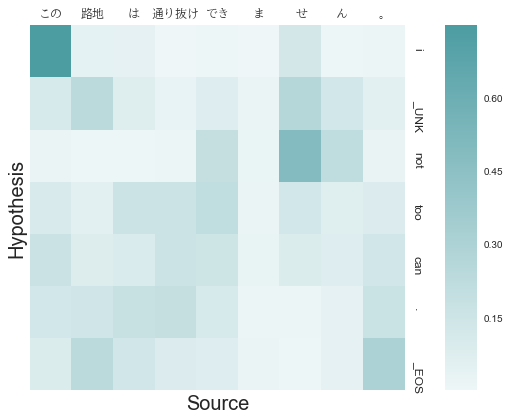

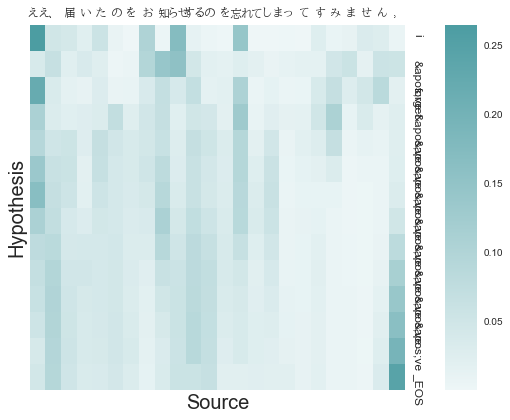

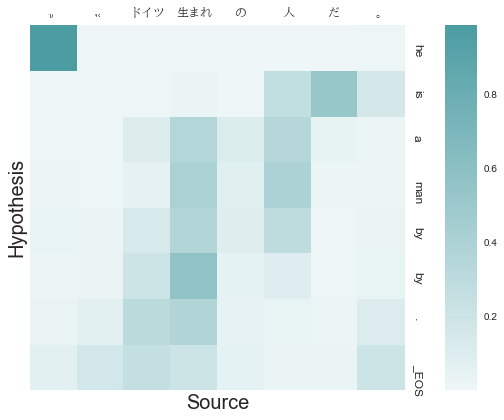

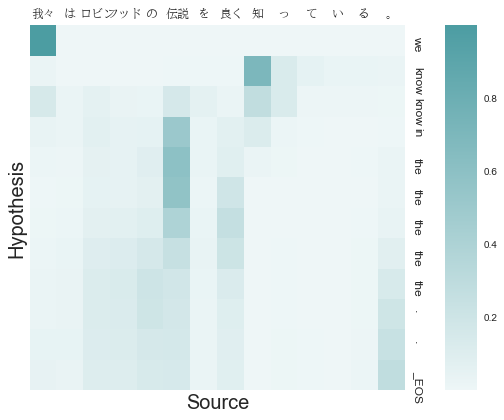

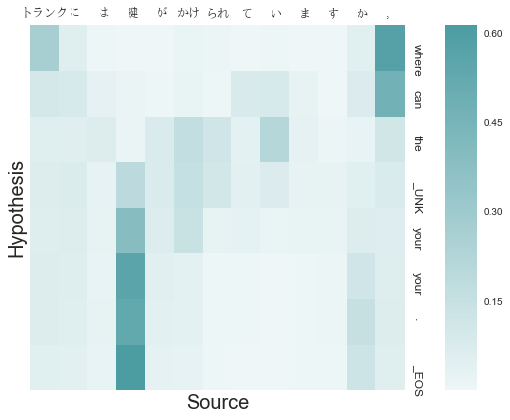

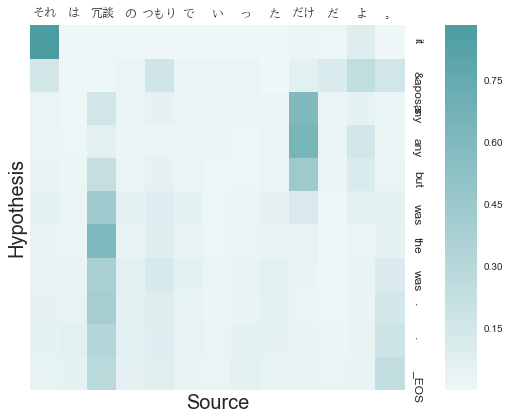

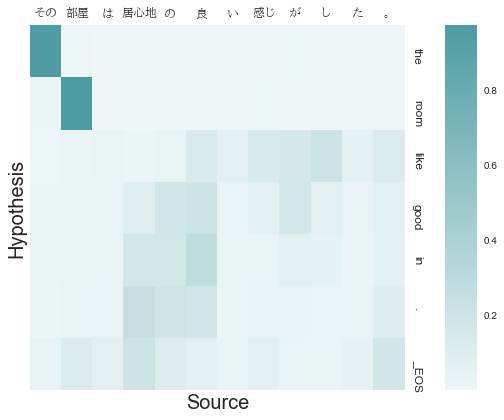

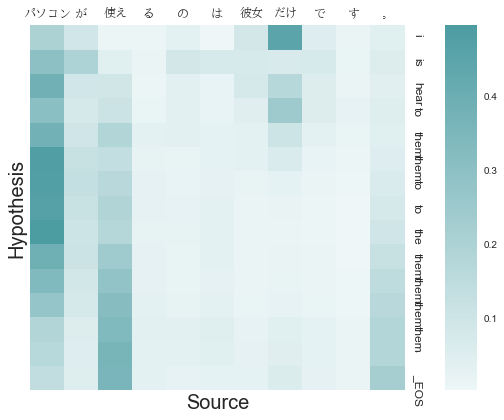

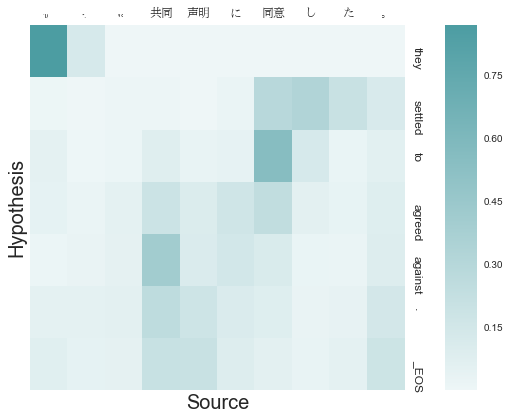

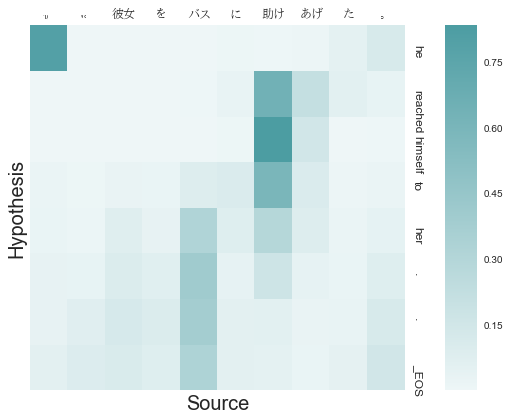

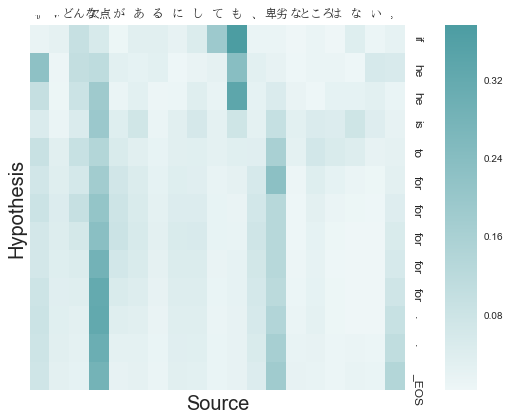

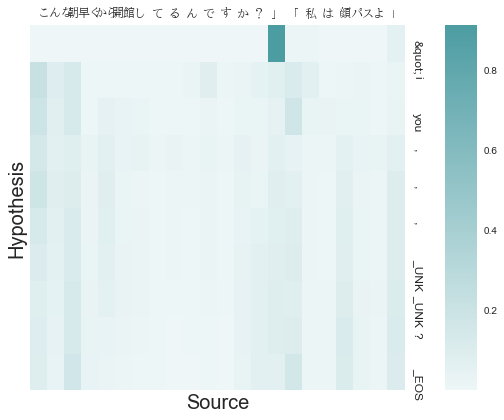

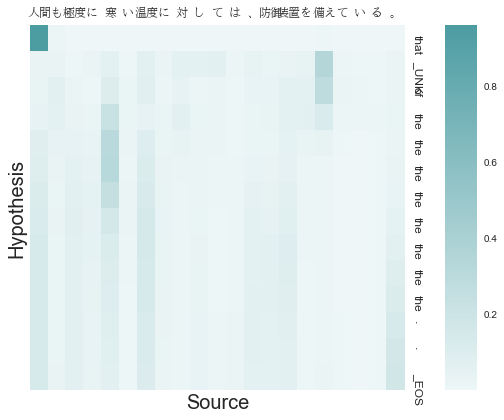

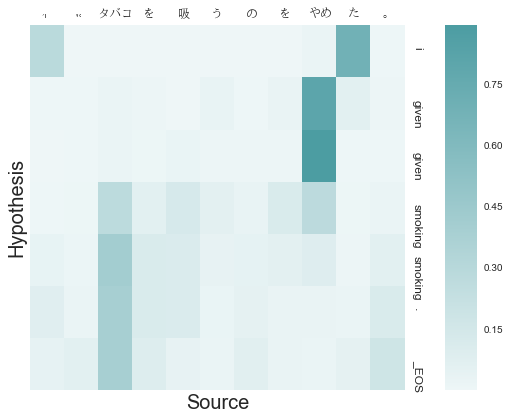

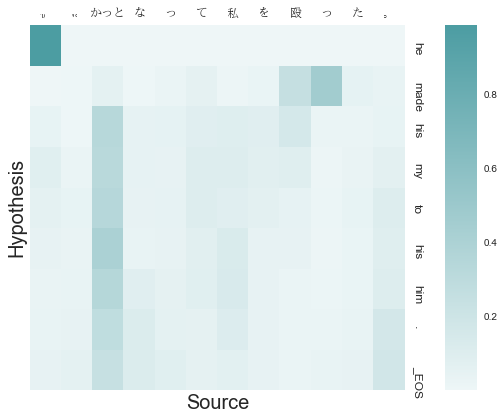

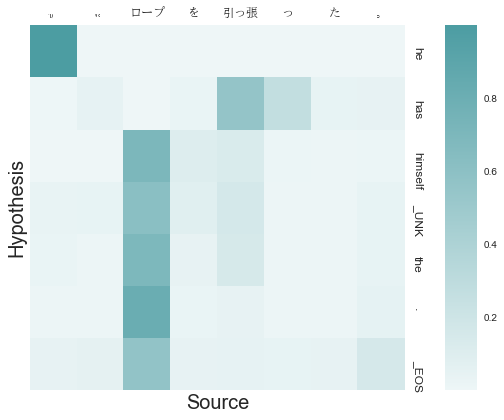

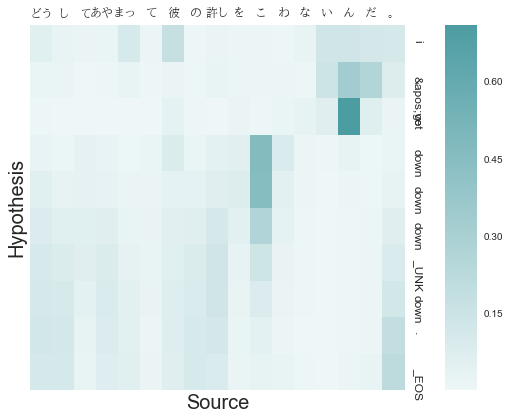

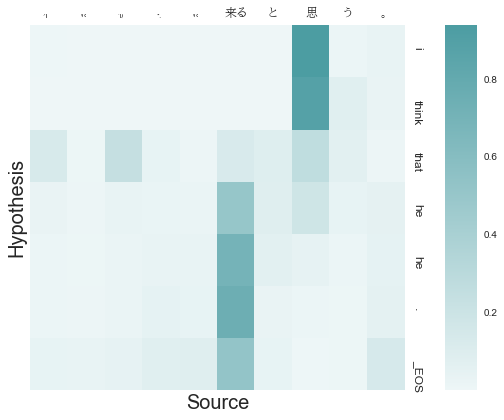

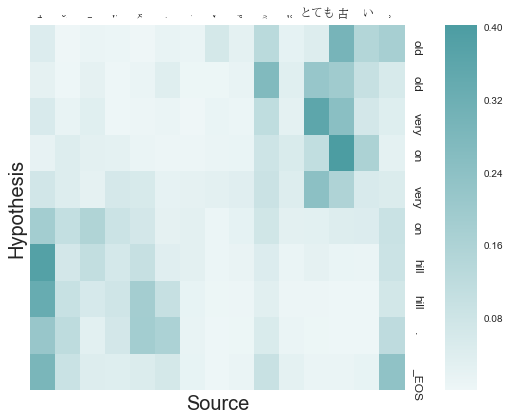

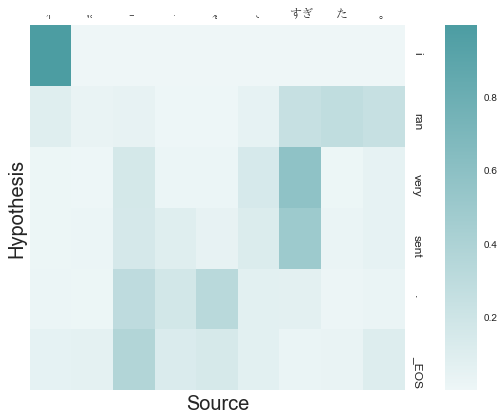

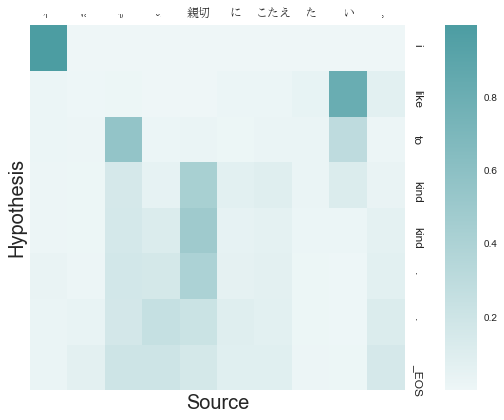

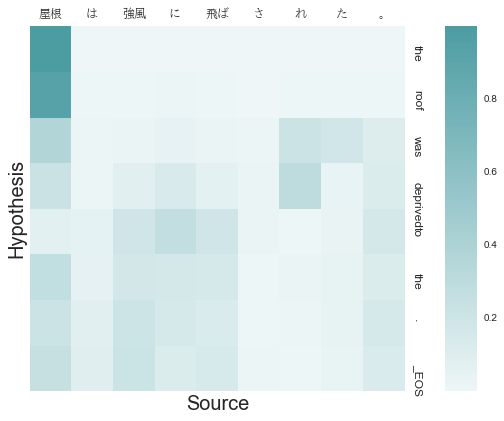

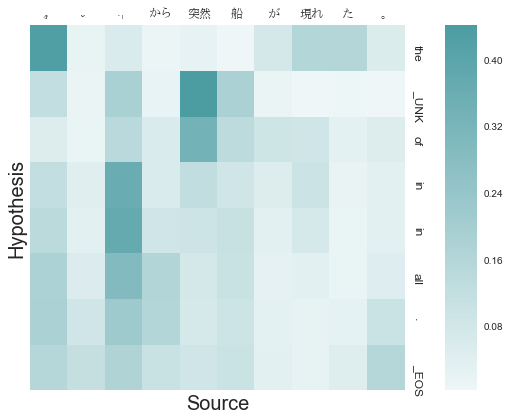

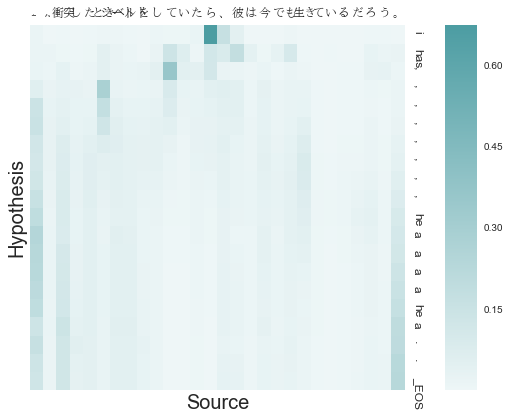

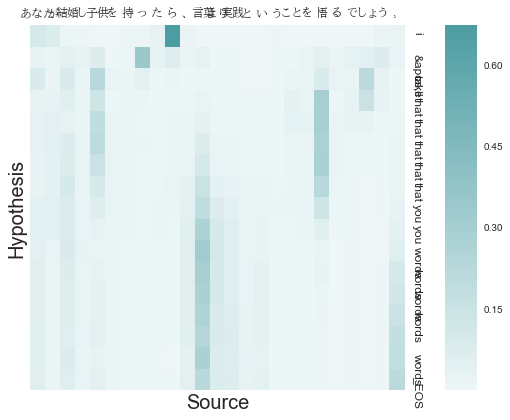

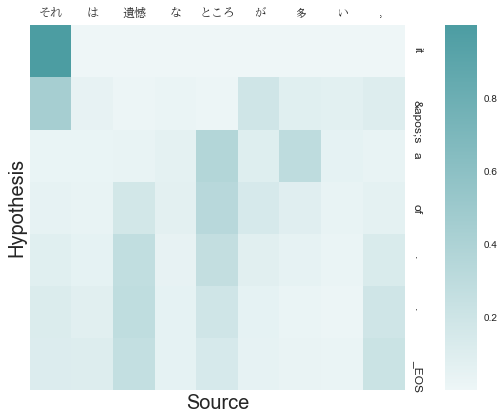

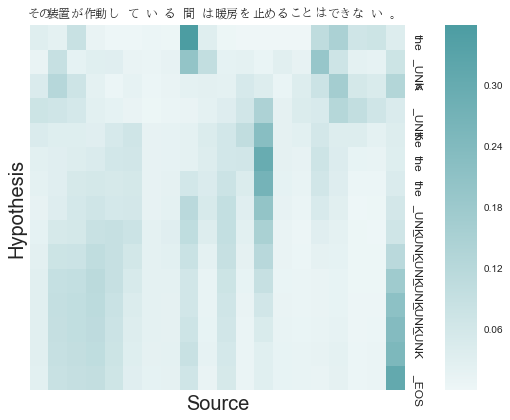

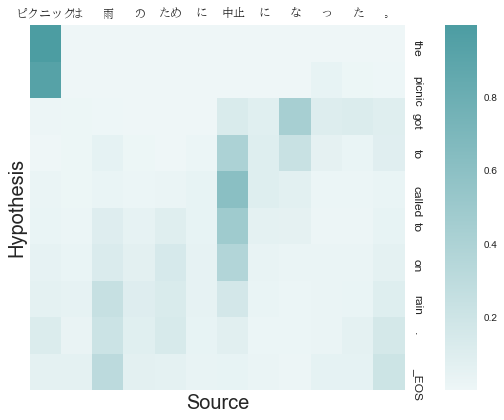

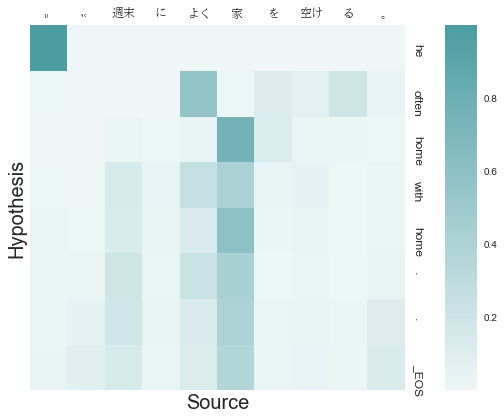

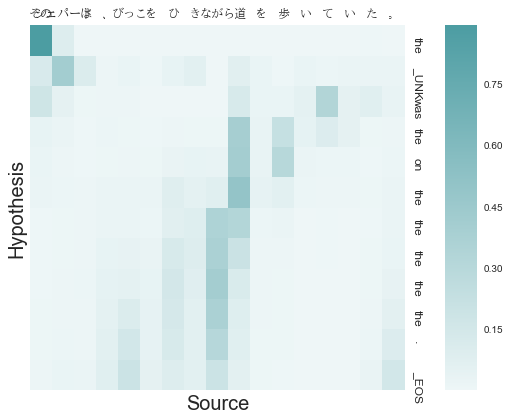

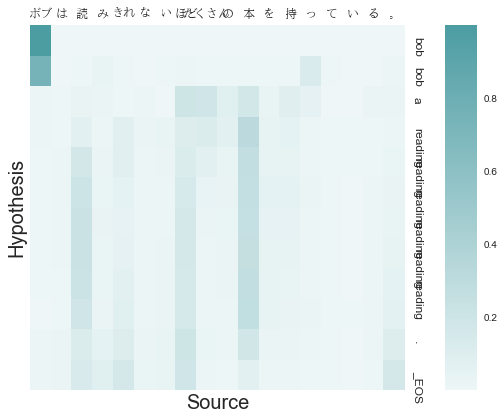

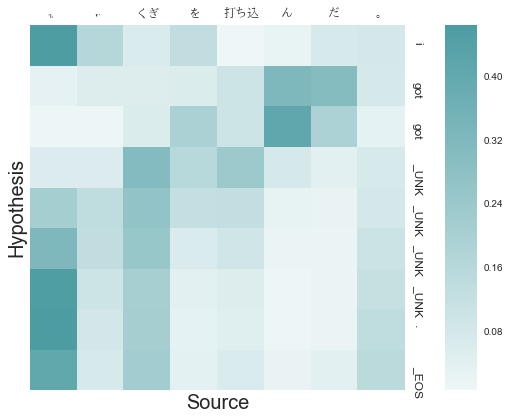

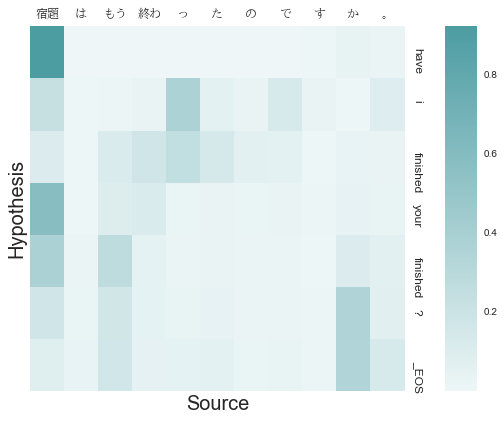

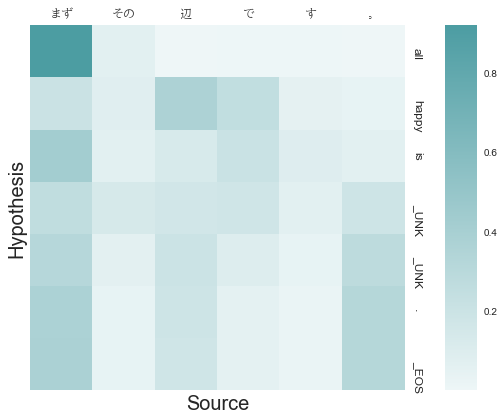

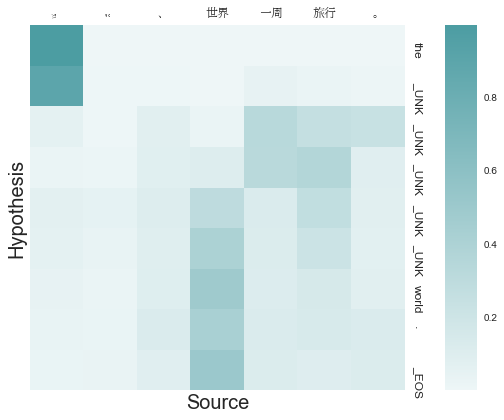

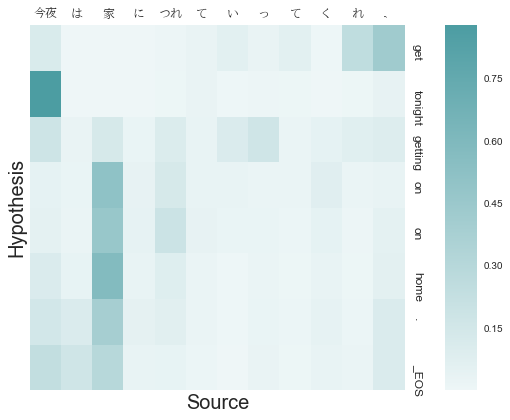

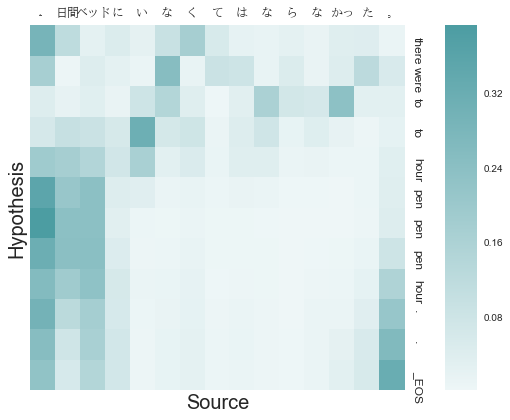

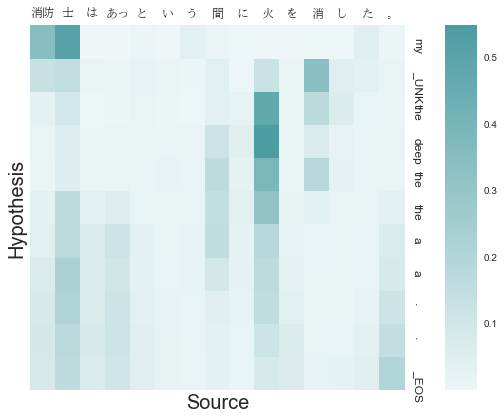

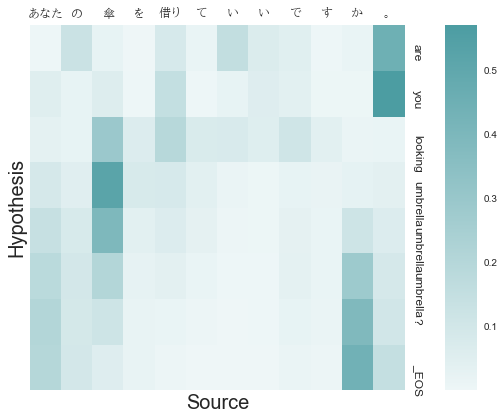

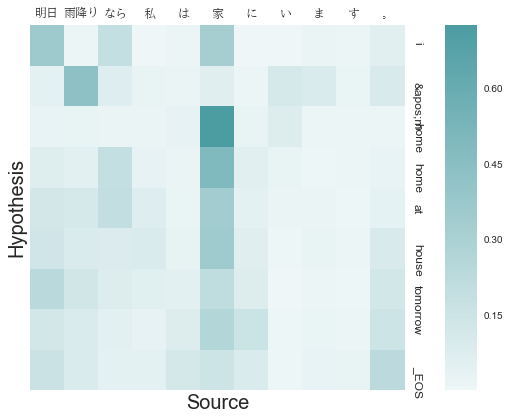

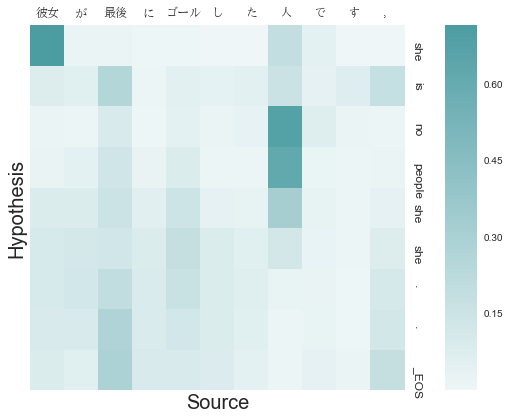

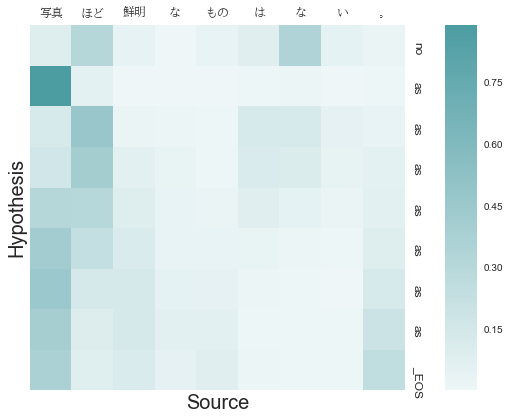

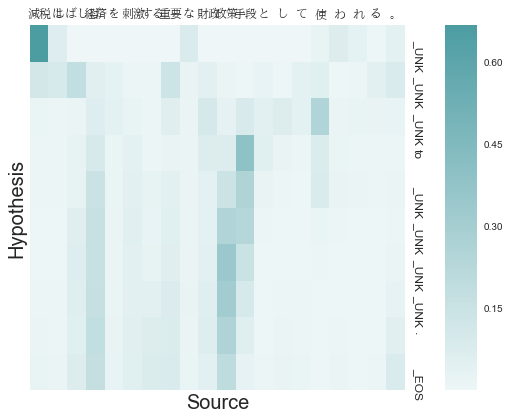

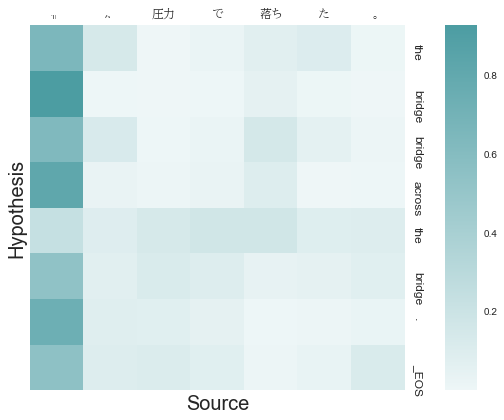

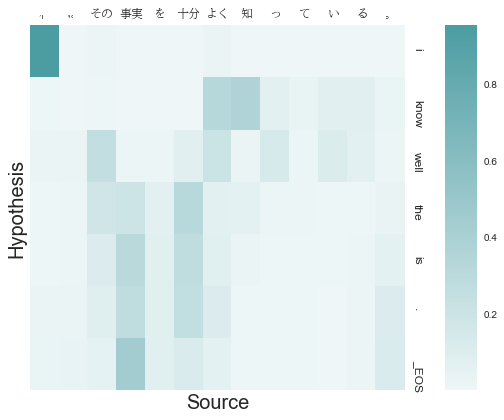

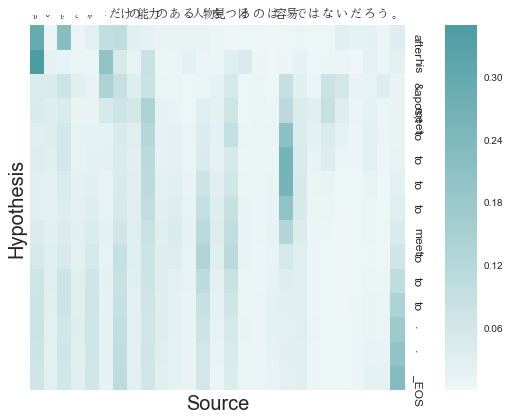

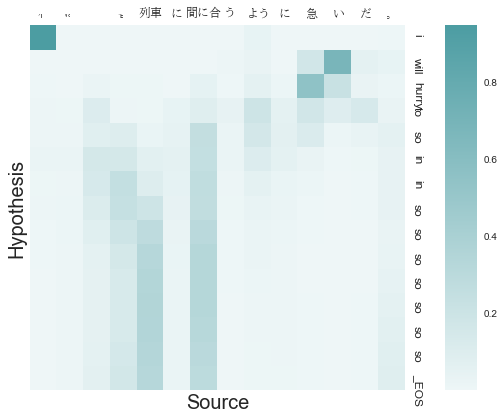

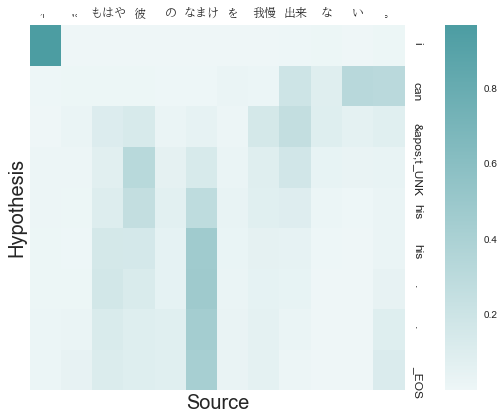

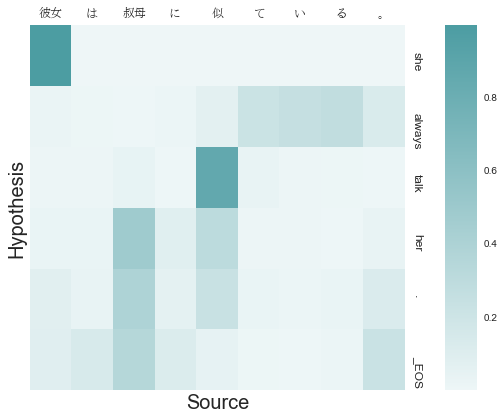

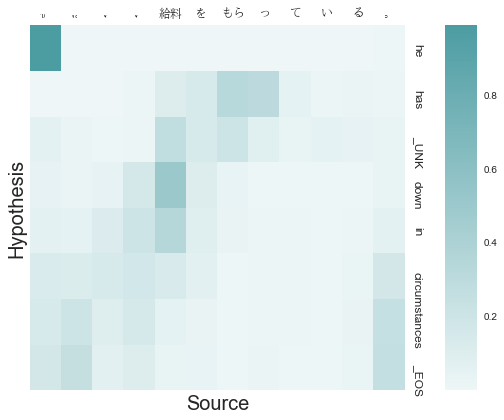

In [5]:
predict(s=10000, num=50, plot=True)